In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

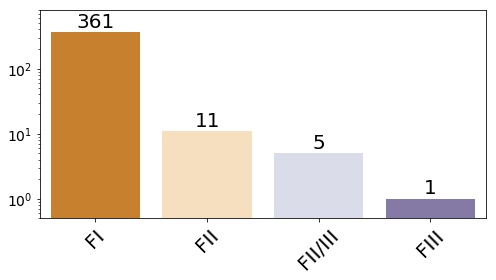

In [3]:
# Breakdown of data by taxonomy and isoform
isoform_counts = raw_kin_df.isoform.value_counts()

groups = {'1': 'FI', 
          '2': 'FII',
          '2_3': 'FII/III', 
          '3': 'FIII'}

fig = plt.figure(figsize=(7,4))

plt.yscale('log')
seaborn.barplot(y=isoform_counts, x=isoform_counts.index, palette='PuOr')
plt.xticks()

for i, (label, count) in enumerate(isoform_counts.iteritems()):
    plt.text(i, 1.2*count, str(count), ha='center', fontsize=20)

plt.ylim(0.5, 800)
plt.ylabel('', fontsize=18)
plt.yticks(fontsize=14)


xticks = [groups[i] for i in isoform_counts.index]
plt.xticks(np.arange(isoform_counts.size), xticks, fontsize=20, rotation=45, ha='center')
plt.tight_layout()

plt.savefig('fig2/fig2_isoform_counts.svg')
plt.savefig('fig2/fig2_isoform_counts.png', dpi=600)

plt.show()

In [4]:
# Counts by taxa. I realize that these categories are not strictly
# mutually exclusive, but we did our best mapping a tree onto 1D.
taxa_counts = raw_kin_df.taxonomy.value_counts()
taxa_counts

C3 plants              215
C4 plants               44
Cyanobacteria           30
Diatoms                 18
Alphaproteobacteria     12
C3-C4 plants            10
Green algae              6
Archaea                  6
Red algae                6
Gammaproteobacteria      5
Carnivorous plants       3
Haptophyte algae         3
C4-like plants           3
Fern                     3
CAM plants               3
Chromophyte algae        2
Bryophyte                2
Gymnosperm               2
Betaproteobacteria       2
Rhodophyte algae         1
Basal angiosperm         1
Macroalgae               1
Name: taxonomy, dtype: int64

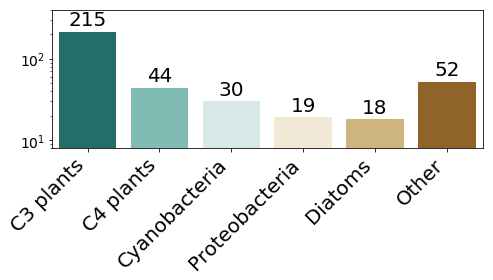

In [5]:
fig = plt.figure(figsize=(7,4))

# Count the proteobacteria together
proteos = ['Alphaproteobacteria', 'Betaproteobacteria', 'Gammaproteobacteria']
proteo_counts = taxa_counts[proteos].sum()
rest_counts = taxa_counts.sum() - taxa_counts[:4].sum() - proteo_counts

ys = np.array(taxa_counts[:4].values.tolist() + [proteo_counts])
labels = np.array(taxa_counts[:4].index.tolist() + ['Proteobacteria'])

# Reorder to be sorted
ys_order = np.argsort(ys)[::-1]
ys = ys[ys_order].tolist() + [rest_counts]
labels = labels[ys_order].tolist() + ['Other']

plt.yscale('log')
seaborn.barplot(y=ys, x=labels, palette='BrBG_r')

for i, (label, count) in enumerate(zip(labels, ys)):
    plt.text(i, 1.2*count, str(count), ha='center', fontsize=20)

plt.ylim(8, 400)
plt.xticks(fontsize=20, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig('fig2/fig2_taxonomy_counts.svg')
plt.savefig('fig2/fig2_taxonomy_counts.png', dpi=600)

plt.show()

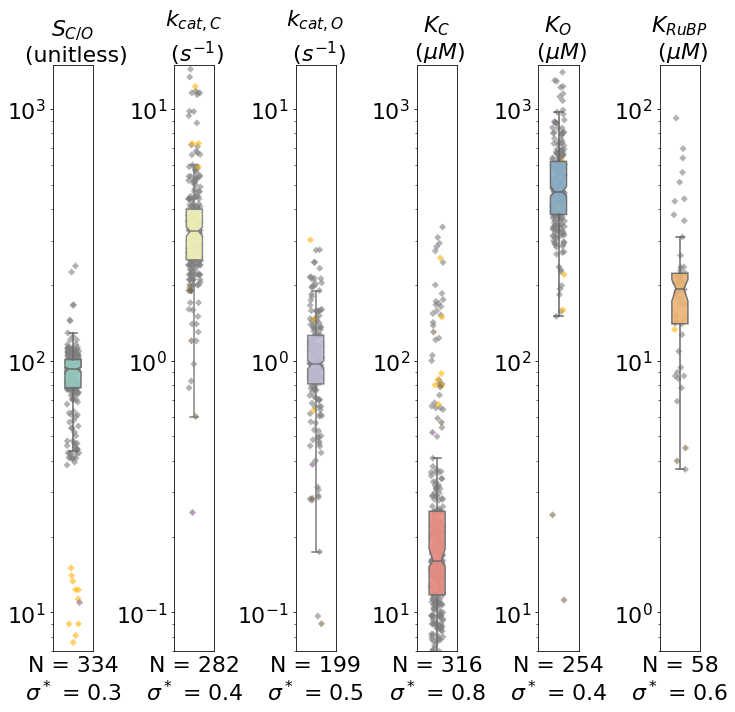

In [6]:
# Description of the data set
figure = plt.figure(figsize=(10,10))

cols = ['S', 'vC', 'vO', 'KC', 'KO', 'KRuBP']
titles = {'S': '$S_{C/O}$', 'vC': '$k_{cat,C}$', 'KC':
          '$K_C$', 'vO': '$k_{cat,O}$', 'KO': '$K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless', 'vC': '$s^{-1}$', 'KC':
         '$\mu M$', 'vO': '$s^{-1}$', 'KO': '$\mu M$',
         'KRuBP': '$\mu M$'}
ylim = {'S': (7, 1500),
        'vC': (0.7e-1, 1.5e1),
        'vO':(0.7e-1, 1.5e1),
        'KC': (7, 1.5e3),
        'KO': (7, 1.5e3),
        'KRuBP': (0.7, 1.5e2)}

nsub = len(cols)
pal = seaborn.color_palette('Set3')

for i, c in enumerate(cols):
    mask = raw_kin_df[c].notnull()
    vals = raw_kin_df[mask][c]
    
    ax = plt.subplot(1, nsub, i+1)
    plt.yscale('log')
    sigma_star = None

    for j, (group, gdf) in enumerate(raw_kin_df.groupby('isoform')):
        color = named_colors[j]
        if group == '1':
            color = 'grey'
            sigma_star = np.nanstd(np.log(gdf[c]))
            
        seaborn.stripplot(y=gdf[c], color=color, jitter=0.15, size=5, marker='D', alpha=0.6, zorder=-1)
        
    seaborn.boxplot(y=raw_kin_df[c], color=pal[i], width=0.4, notch=True, bootstrap=1000, zorder=10,
                    boxprops=dict(alpha=.9), showfliers=False)
            
    nvals = raw_kin_df[c].notnull().sum()
    xlabel = 'N = %d\n$\sigma^*$ = %.1f' % (nvals, sigma_star)

    plt.ylim(*ylim[c])
    plt.xticks([])
    plt.yticks(fontsize=22)
    plt.ylabel('')
    plt.xlabel(xlabel, fontsize=22, ha='center')
    
    title = '%s \n (%s)' % (titles[c], units[c])
    plt.title(title, fontsize=22)
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('fig2/fig2_data_summary.svg')
plt.savefig('fig2/fig2_data_summary.png', dpi=600, bbox_inches='tight', pad_inches=0.2)

plt.show()

In [7]:
# print some statistics about the full dataset
full_dataset_df = pd.read_csv('../data/DatasetS4_RubiscoKineticsFull_Merged.csv')

# TODO correct minor errors in long refs
refs = full_dataset_df.short_ref.unique().size

print('Data from', refs, 'references')

Data from 66 references


In [8]:
# print some statistics about the data passing filters
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(kin_df.species.unique().size, 'unique species among those with core kinetic data')

print(raw_kin_df.kon_C.notnull().sum(), 'kcatC/KC values overall')
print(raw_kin_df.kon_O.notnull().sum(), 'kcatO/KO values overall')

378 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
184 unique species among those with core kinetic data
274 kcatC/KC values overall
199 kcatO/KO values overall


In [9]:
# Counts by taxa. I realize that these categories are not strictly
# mutually exclusive, but we did our best mapping a tree onto 1D.
species_counts = raw_kin_df.species.value_counts()
species_counts

Spinacia oleracea                       12
Synechococcus 6301                      10
Rhodospirillum rubrum                    9
Nicotiana tabacum                        8
Triticum aestivum                        7
Zea mays                                 4
Flaveria pringlei                        4
Amaranthus hybridus                      3
Chlamydomonas reinhardtii                3
Espeletia schultzii                      3
Methanococcoides burtonii                3
Glycine max                              3
Synechococcus 7002                       3
Flaveria floridana                       2
Cyanobium PCC7001                        2
Cylindrotheca N1                         2
Setaria viridis                          2
Medicago sativa                          2
Limonium magallufianum                   2
Potulaca oleraca                         2
Sorghum bicolor                          2
Nicotiana tabacum L. cv. W38             2
Flaveria bidentis                        2
Allochromat